# TP Coding a GAN in Pytorch

Author : Alasdair Newson

alasdair.newson@telecom-paris.fr

## Objective:

The goal of this TP is to explore GANs applied to the mnist (and possibly cifar10) datasets.

We will start with the mnist dataset.

### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE)

First of all, let's load some packages

In [1]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import pickle
import copy
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

def pytorch_to_numpy(x):
  return x.detach().numpy()


# Decide which device we want to run on
if (torch.cuda.is_available()):
  device = torch.device("cuda:0")
else:
  device = "cpu"


## 1/ Loading the data

We define a function to load the mnist or cifar10 datasets. Note, we normalise the data between -1 and 1 here (this is often the case for GANs).

In [2]:
# create a random seed for reproducible results
random_seed = 1
torch.manual_seed(random_seed)

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# MNIST Dataset
mnist_trainset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
mnist_testset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

#create data loader with smaller dataset size
max_mnist_size = 1000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0] 
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
max_mnist_size = 512
mnist_testset_reduced = torch.utils.data.random_split(mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0] 
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset_reduced, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 133360634.49it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 128321709.56it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 108443745.05it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 25265953.27it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [3]:
n_rows = mnist_trainset_reduced.dataset.train_data.shape[1]
n_cols = mnist_trainset_reduced.dataset.train_data.shape[2]
n_channels = 1
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## 2/ GAN parameters

In [4]:
## GAN parameters
z_dim = 10
batch_size = 64
## parameters for training
n_epochs = 400
n_iters_inner=1	#number of internal loops
sample_interval=100
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

# hidden dimensions : careful, the order here is with respect to the generator, and the discriminator is in the opposite order
h_dim_1 = 256
h_dim_2 = 512

## 3/ Model architecture

Now, we define the model architecture.

For the first dataset, mnist, we are going to use fully connected layers. Implement the following architecture, for the generator and the discriminator :

Generator :
- Dense layer, to size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 784
- Tanh activation
- Reshape to size $28 \times 28 \times 1$

Discriminator :
- Flatten
- Dense layer, to size 512
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 256
- Leaky ReLU ($\alpha=0.2$)
- Dense layer, output size 1
- Sigmoid activation

In [21]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, z_dim, h_dim_1, h_dim_2, n_rows,n_cols,n_channels):
    super(Generator, self).__init__()
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    self.fc1 = nn.Linear(z_dim, self.h_dim_1) # FILL IN HERE
    self.fc2 = nn.Linear(self.h_dim_1, self.h_dim_2) # FILL IN HERE
    self.fc3 = nn.Linear(self.h_dim_2, self.n_pixels*self.n_channels) # FILL IN HERE

    self.leaky_relu = nn.LeakyReLU(0.2)
    self.tanh = nn.Tanh()
  def forward(self, z):
    y = self.fc1(z)
    y = self.leaky_relu(y) 
    y = self.fc2(y)
    y = self.leaky_relu(y) 
    y = self.fc3(y)
    y = self.tanh(y)
    y = y.view(-1, self.n_channels, self.n_rows, self.n_cols) # Maybe n_channels in the first channel

    return(y)


In [22]:
class Discriminator(nn.Module):
  def __init__(self, h_dim_2, h_dim_1, z_dim, n_rows,n_cols,n_channels):
    super(Discriminator, self).__init__()

    self.n_rows = n_rows
    self.n_cols = n_cols
    self.n_channels = n_channels
    self.n_pixels = (self.n_rows)*(self.n_cols)
    self.h_dim_1 = h_dim_1
    self.h_dim_2 = h_dim_2
    self.z_dim = z_dim

    self.fc1 = nn.Linear(self.n_pixels, h_dim_2)
    self.fc2 = nn.Linear(h_dim_2, h_dim_1)
    self.fc3 = nn.Linear(h_dim_1, 1)

    self.leaky_relu = nn.LeakyReLU(0.2)
    self.sigmoid = nn.Sigmoid()
  def forward(self, x):
    y = x.view(-1, self.n_channels*self.n_pixels) # FILL IN HERE
    y = self.fc1(y)
    y = self.leaky_relu(y)
    y = self.fc2(y)
    y = self.leaky_relu(y)
    y = self.fc3(y)
    y = self.sigmoid(y)

    return y




Create generator and discriminator 

In [23]:
gen_model = Generator(z_dim, h_dim_1, h_dim_2, 28, 28, 1) # FILL IN HERE
# Print the model
print(gen_model)

disc_model = Discriminator(h_dim_2, h_dim_1, z_dim, 28, 28, 1) # FILL IN HERE
# Print the model
print(disc_model)

Generator(
  (fc1): Linear(in_features=10, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=784, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (tanh): Tanh()
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (sigmoid): Sigmoid()
)


## 4/ Loss function


The GAN loss function is the following :
\begin{equation}
	\min_{G} \max_{D} \mathbb{E}_{x \in p_{data}} \left[ \log D(x)\right] +
	\mathbb{E}_{z \in p_{z}}\left[ \log \left( 1 - D(G(z)) \right)\right],
\end{equation}
where $G$ is the generator, $D$ is the discriminator, $z$ is the latent code, which follows a normal distribution.

You should notice that this is extremely similar to the binary cross-entropy function. Therefore, there is an intelligent way to train the discriminator : we give it first a batch of real images, and label them as real, and secondly we give a batch of fake images and label them as fake. Therefore, the discriminator training itself is done in two sequential steps (first true, then fake). If the labels are correctly chosen (further on, during training), you can (and __should__) use the binary cross-entropy function.

The generator loss, however, must be specified as :
- $mean(\log(1-D(G(z))))$

You can use the ```torch.mean``` function for this purpose.


The training is carried out sequentially : first we execute a few training steps on the discriminator, and then one on the generator. Therefore, we use two loops : one to train the discriminator (the internal loop) and one to train the generator (external loop, ie. the number of epochs). The GAN training algorithm is as follows :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$



In [24]:
# Setup Adam optimizers for both G and D
optimizer_disc = optim.Adam(disc_model.parameters(), lr=lr, betas=(beta_1, 0.999))
optimizer_gen = optim.Adam(gen_model.parameters(), lr=lr, betas=(beta_1, 0.999))

# criterion used for the discriminator loss
bce_criterion = nn.BCELoss() # FILL IN HERE

# criterion used for the generator loss
def loss_fn_gen(d_gen_data):
  loss_gen = torch.mean(torch.log(1 - d_gen_data))  # FILL IN CODE
  return loss_gen

### Sampling function

We now create a function to sample several images during training (to follow the convergence of the network)

In [35]:
def sample_images(generator,z_dim, rand_seed=30):
  #np.random.seed(rand_seed)
  r, c = 5, 5
  z_random = torch.randn(r * c, 1, z_dim, dtype=torch.float, device='cpu') #np.random.normal(0, 1, (r * c, z_dim))
  
  gen_imgs = np.transpose( generator(z_random).cpu().detach().numpy() , (0,2,3,1))

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      #black and white images
      if(gen_imgs.shape[3] == 1):
        axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
      elif(gen_imgs.shape[3] == 3):   #colour images
        gen_imgs_temp = gen_imgs.copy()
        gen_imgs_temp = 255.*np.clip(gen_imgs_temp,0.0,1.0) 
        axs[i,j].imshow(gen_imgs_temp[cnt, :,:,:].astype(np.uint8))
      else:
        print('Error, unsupported channel size. Dude, I don''t know what you want me to do.\
            I can''t handle this data. You''ve made me very sad ...')
      axs[i,j].axis('off')
      cnt += 1
  plt.show()

## 5/ Training

We are now ready to train the network. Here is the training algorithm again :

- For $i=0$ to $n-1$
  - For $j=0$ to $m-1$
    - $x \leftarrow$ random batch of data
    - $z \leftarrow$ random batch of latent codes
    - Train discriminator on real images $x$
    - Train discriminator on fake images $G(z)$
  - $z \leftarrow$ random batch of latent codes
  - Train discriminator on fake images $G(z)$

You can use ```np.random.normal``` to create a batch of random latent codes, and ```np.random.randint``` to create a batch of random images.

You can then train the discriminator and the generator using the ```train_on_batch``` function.

We do not worry here about looping over the whole database : just create a random batch at each iteration.

Starting Training
[0/400][0/16] 	Loss_D: 1.0066	Loss_G: -0.5332	D(x): 0.7961	D(G(z)): 0.5396


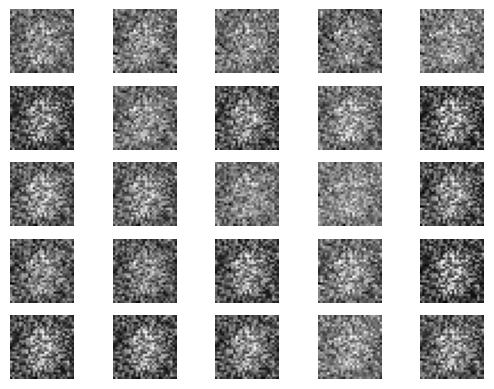

[1/400][0/16] 	Loss_D: 1.0201	Loss_G: -0.4631	D(x): 0.7964	D(G(z)): 0.5462
[2/400][0/16] 	Loss_D: 1.1827	Loss_G: -0.4109	D(x): 0.8095	D(G(z)): 0.6182
[3/400][0/16] 	Loss_D: 1.2608	Loss_G: -0.4552	D(x): 0.7897	D(G(z)): 0.6378
[4/400][0/16] 	Loss_D: 0.5361	Loss_G: -0.1777	D(x): 0.9071	D(G(z)): 0.3535
[5/400][0/16] 	Loss_D: 0.6407	Loss_G: -0.2810	D(x): 0.8590	D(G(z)): 0.3844
[6/400][0/16] 	Loss_D: 1.6342	Loss_G: -0.8366	D(x): 0.5061	D(G(z)): 0.6080
[7/400][0/16] 	Loss_D: 0.9639	Loss_G: -0.3627	D(x): 0.7375	D(G(z)): 0.4807
[8/400][0/16] 	Loss_D: 1.4258	Loss_G: -0.4385	D(x): 0.7477	D(G(z)): 0.6757
[9/400][0/16] 	Loss_D: 1.0524	Loss_G: -0.5645	D(x): 0.6080	D(G(z)): 0.4192
[10/400][0/16] 	Loss_D: 1.5256	Loss_G: -0.3636	D(x): 0.7542	D(G(z)): 0.7088
[11/400][0/16] 	Loss_D: 0.5912	Loss_G: -0.1764	D(x): 0.8273	D(G(z)): 0.3286
[12/400][0/16] 	Loss_D: 1.2101	Loss_G: -0.4221	D(x): 0.6356	D(G(z)): 0.5234
[13/400][0/16] 	Loss_D: 0.3622	Loss_G: -0.1641	D(x): 0.7984	D(G(z)): 0.1226
[14/400][0/16] 	Loss_

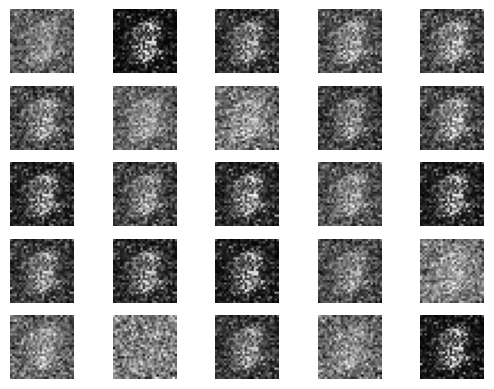

[26/400][0/16] 	Loss_D: 0.6164	Loss_G: -0.2070	D(x): 0.7442	D(G(z)): 0.2560
[27/400][0/16] 	Loss_D: 0.1389	Loss_G: -0.0610	D(x): 0.9444	D(G(z)): 0.0773
[28/400][0/16] 	Loss_D: 0.2766	Loss_G: -0.0878	D(x): 0.9095	D(G(z)): 0.1621
[29/400][0/16] 	Loss_D: 0.4014	Loss_G: -0.1600	D(x): 0.8229	D(G(z)): 0.1638
[30/400][0/16] 	Loss_D: 0.4005	Loss_G: -0.0930	D(x): 0.8663	D(G(z)): 0.2074
[31/400][0/16] 	Loss_D: 0.1332	Loss_G: -0.0509	D(x): 0.9514	D(G(z)): 0.0780
[32/400][0/16] 	Loss_D: 0.1454	Loss_G: -0.0551	D(x): 0.9255	D(G(z)): 0.0613
[33/400][0/16] 	Loss_D: 0.0972	Loss_G: -0.0367	D(x): 0.9566	D(G(z)): 0.0491
[34/400][0/16] 	Loss_D: 0.1155	Loss_G: -0.0369	D(x): 0.9690	D(G(z)): 0.0792
[35/400][0/16] 	Loss_D: 0.1777	Loss_G: -0.0790	D(x): 0.9823	D(G(z)): 0.1470
[36/400][0/16] 	Loss_D: 3.1621	Loss_G: -0.0107	D(x): 0.9981	D(G(z)): 0.9547
[37/400][0/16] 	Loss_D: 0.1250	Loss_G: -0.0521	D(x): 0.9537	D(G(z)): 0.0707
[38/400][0/16] 	Loss_D: 0.1531	Loss_G: -0.0373	D(x): 0.9778	D(G(z)): 0.1193
[39/400][0/1

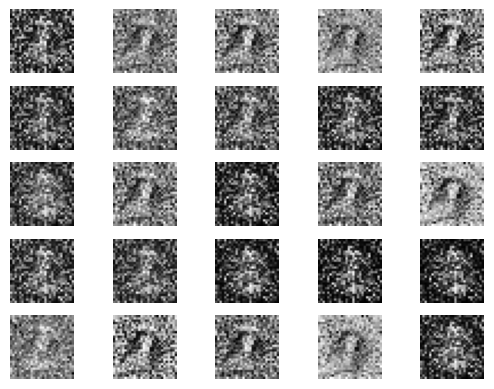

[51/400][0/16] 	Loss_D: 0.0634	Loss_G: -0.0274	D(x): 0.9747	D(G(z)): 0.0360
[52/400][0/16] 	Loss_D: 0.0316	Loss_G: -0.0167	D(x): 0.9889	D(G(z)): 0.0200
[53/400][0/16] 	Loss_D: 0.0209	Loss_G: -0.0110	D(x): 0.9924	D(G(z)): 0.0130
[54/400][0/16] 	Loss_D: 0.0212	Loss_G: -0.0114	D(x): 0.9928	D(G(z)): 0.0138
[55/400][0/16] 	Loss_D: 0.0347	Loss_G: -0.0179	D(x): 0.9842	D(G(z)): 0.0180
[56/400][0/16] 	Loss_D: 0.1000	Loss_G: -0.0255	D(x): 0.9338	D(G(z)): 0.0165
[57/400][0/16] 	Loss_D: 0.4602	Loss_G: -0.0840	D(x): 0.7742	D(G(z)): 0.1559
[58/400][0/16] 	Loss_D: 0.1930	Loss_G: -0.0747	D(x): 0.9220	D(G(z)): 0.0989
[59/400][0/16] 	Loss_D: 0.3224	Loss_G: -0.0197	D(x): 0.9733	D(G(z)): 0.2532
[60/400][0/16] 	Loss_D: 0.4319	Loss_G: -1.7730	D(x): 0.7870	D(G(z)): 0.0991
[61/400][0/16] 	Loss_D: 0.2735	Loss_G: -0.1124	D(x): 0.8749	D(G(z)): 0.1140
[62/400][0/16] 	Loss_D: 0.0876	Loss_G: -0.0308	D(x): 0.9560	D(G(z)): 0.0377
[63/400][0/16] 	Loss_D: 0.0679	Loss_G: -0.0288	D(x): 0.9750	D(G(z)): 0.0406
[64/400][0/1

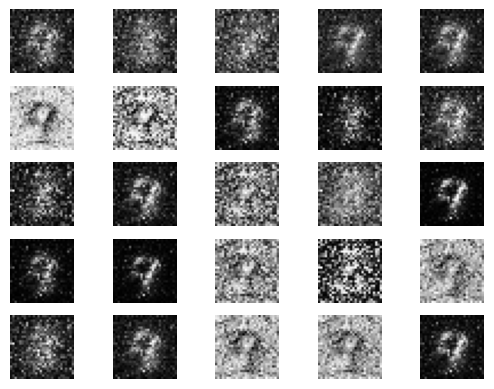

[76/400][0/16] 	Loss_D: 0.0535	Loss_G: -0.0157	D(x): 0.9735	D(G(z)): 0.0167
[77/400][0/16] 	Loss_D: 0.6731	Loss_G: -0.0011	D(x): 0.9780	D(G(z)): 0.4539
[78/400][0/16] 	Loss_D: 0.1514	Loss_G: -0.0502	D(x): 0.9700	D(G(z)): 0.0999
[79/400][0/16] 	Loss_D: 0.0463	Loss_G: -0.0131	D(x): 0.9816	D(G(z)): 0.0230
[80/400][0/16] 	Loss_D: 0.0591	Loss_G: -0.0157	D(x): 0.9830	D(G(z)): 0.0388
[81/400][0/16] 	Loss_D: 0.1949	Loss_G: -0.0115	D(x): 0.8963	D(G(z)): 0.0045
[82/400][0/16] 	Loss_D: 2.2021	Loss_G: -0.7920	D(x): 0.4500	D(G(z)): 0.0002
[83/400][0/16] 	Loss_D: 0.7074	Loss_G: -0.1000	D(x): 0.9114	D(G(z)): 0.4058
[84/400][0/16] 	Loss_D: 0.1611	Loss_G: -0.0442	D(x): 0.9563	D(G(z)): 0.1002
[85/400][0/16] 	Loss_D: 0.1130	Loss_G: -0.0379	D(x): 0.9721	D(G(z)): 0.0790
[86/400][0/16] 	Loss_D: 0.1377	Loss_G: -0.0162	D(x): 0.9732	D(G(z)): 0.0986
[87/400][0/16] 	Loss_D: 0.0929	Loss_G: -0.0295	D(x): 0.9572	D(G(z)): 0.0415
[88/400][0/16] 	Loss_D: 0.1348	Loss_G: -0.0057	D(x): 0.9832	D(G(z)): 0.1084
[89/400][0/1

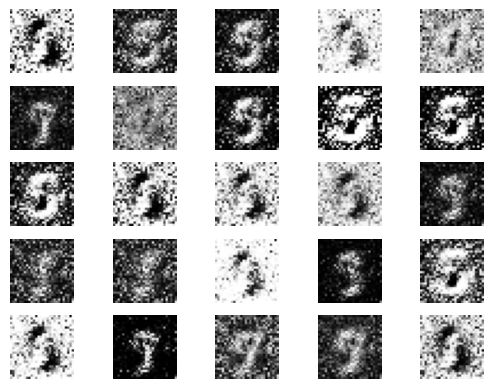

[101/400][0/16] 	Loss_D: 0.2104	Loss_G: -0.0658	D(x): 0.9810	D(G(z)): 0.1500
[102/400][0/16] 	Loss_D: 0.1382	Loss_G: -0.0365	D(x): 0.9632	D(G(z)): 0.0861
[103/400][0/16] 	Loss_D: 0.6550	Loss_G: -0.0836	D(x): 0.7316	D(G(z)): 0.0020
[104/400][0/16] 	Loss_D: 5.3420	Loss_G: -2.0497	D(x): 0.1055	D(G(z)): 0.0300
[105/400][0/16] 	Loss_D: 0.1018	Loss_G: -0.0347	D(x): 0.9600	D(G(z)): 0.0557
[106/400][0/16] 	Loss_D: 0.0659	Loss_G: -0.0195	D(x): 0.9710	D(G(z)): 0.0324
[107/400][0/16] 	Loss_D: 0.1213	Loss_G: -0.0247	D(x): 0.9272	D(G(z)): 0.0307
[108/400][0/16] 	Loss_D: 0.1712	Loss_G: -0.0244	D(x): 0.9280	D(G(z)): 0.0661
[109/400][0/16] 	Loss_D: 5.5304	Loss_G: -1.6077	D(x): 0.9943	D(G(z)): 0.9950
[110/400][0/16] 	Loss_D: 0.2577	Loss_G: -0.0714	D(x): 0.8559	D(G(z)): 0.0545
[111/400][0/16] 	Loss_D: 0.1970	Loss_G: -0.0654	D(x): 0.8941	D(G(z)): 0.0565
[112/400][0/16] 	Loss_D: 0.3078	Loss_G: -0.0812	D(x): 0.8622	D(G(z)): 0.0974
[113/400][0/16] 	Loss_D: 0.6121	Loss_G: -0.0353	D(x): 0.8992	D(G(z)): 0.3650

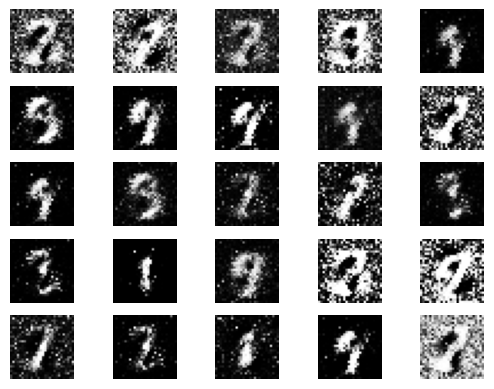

[126/400][0/16] 	Loss_D: 0.3670	Loss_G: -0.1905	D(x): 0.7885	D(G(z)): 0.0408
[127/400][0/16] 	Loss_D: 0.2424	Loss_G: -0.0768	D(x): 0.8785	D(G(z)): 0.0732
[128/400][0/16] 	Loss_D: 0.2877	Loss_G: -0.0181	D(x): 0.9626	D(G(z)): 0.1944
[129/400][0/16] 	Loss_D: 0.1750	Loss_G: -0.0630	D(x): 0.9179	D(G(z)): 0.0653
[130/400][0/16] 	Loss_D: 0.1245	Loss_G: -0.0323	D(x): 0.9314	D(G(z)): 0.0422
[131/400][0/16] 	Loss_D: 0.3973	Loss_G: -0.0205	D(x): 0.9538	D(G(z)): 0.2682
[132/400][0/16] 	Loss_D: 0.2821	Loss_G: -0.1257	D(x): 0.9384	D(G(z)): 0.1748
[133/400][0/16] 	Loss_D: 0.1844	Loss_G: -0.1294	D(x): 0.8876	D(G(z)): 0.0215
[134/400][0/16] 	Loss_D: 0.2234	Loss_G: -0.0916	D(x): 0.8690	D(G(z)): 0.0402
[135/400][0/16] 	Loss_D: 1.6310	Loss_G: -0.0001	D(x): 0.9913	D(G(z)): 0.7458
[136/400][0/16] 	Loss_D: 0.1591	Loss_G: -0.0416	D(x): 0.9166	D(G(z)): 0.0490
[137/400][0/16] 	Loss_D: 0.4194	Loss_G: -0.0247	D(x): 0.8304	D(G(z)): 0.0111
[138/400][0/16] 	Loss_D: 0.1996	Loss_G: -0.1254	D(x): 0.8724	D(G(z)): 0.0306

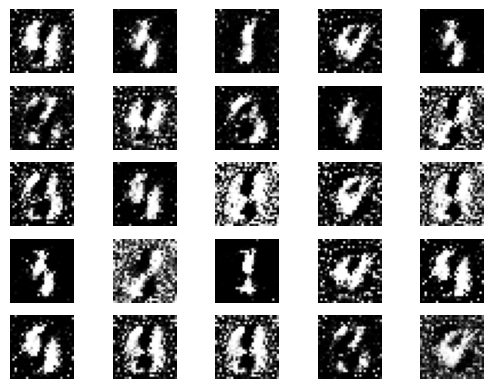

[151/400][0/16] 	Loss_D: 0.1674	Loss_G: -0.0520	D(x): 0.9263	D(G(z)): 0.0731
[152/400][0/16] 	Loss_D: 0.0741	Loss_G: -0.0279	D(x): 0.9637	D(G(z)): 0.0239
[153/400][0/16] 	Loss_D: 0.0806	Loss_G: -0.0161	D(x): 0.9465	D(G(z)): 0.0141
[154/400][0/16] 	Loss_D: 0.0621	Loss_G: -0.0123	D(x): 0.9627	D(G(z)): 0.0195
[155/400][0/16] 	Loss_D: 2.3463	Loss_G: -0.0000	D(x): 0.9985	D(G(z)): 0.8246
[156/400][0/16] 	Loss_D: 0.1914	Loss_G: -0.0491	D(x): 0.9373	D(G(z)): 0.0646
[157/400][0/16] 	Loss_D: 0.3261	Loss_G: -0.0066	D(x): 0.9707	D(G(z)): 0.2251
[158/400][0/16] 	Loss_D: 0.3639	Loss_G: -0.0065	D(x): 0.9739	D(G(z)): 0.2677
[159/400][0/16] 	Loss_D: 0.0956	Loss_G: -0.0476	D(x): 0.9534	D(G(z)): 0.0310
[160/400][0/16] 	Loss_D: 0.0800	Loss_G: -0.0270	D(x): 0.9563	D(G(z)): 0.0184
[161/400][0/16] 	Loss_D: 0.0858	Loss_G: -0.0235	D(x): 0.9500	D(G(z)): 0.0137
[162/400][0/16] 	Loss_D: 0.2397	Loss_G: -0.5007	D(x): 0.9166	D(G(z)): 0.0436
[163/400][0/16] 	Loss_D: 0.1663	Loss_G: -0.0618	D(x): 0.9128	D(G(z)): 0.0320

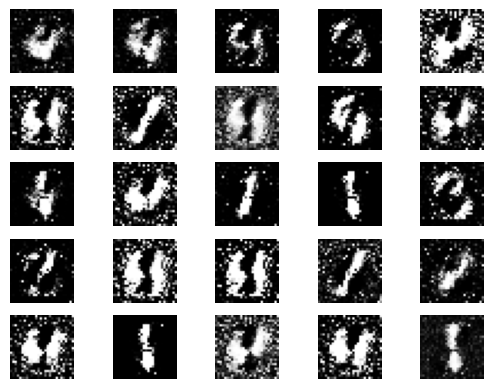

[176/400][0/16] 	Loss_D: 0.2635	Loss_G: -0.0322	D(x): 0.8754	D(G(z)): 0.0244
[177/400][0/16] 	Loss_D: 0.1582	Loss_G: -0.0445	D(x): 0.9400	D(G(z)): 0.0593
[178/400][0/16] 	Loss_D: 0.1646	Loss_G: -0.0173	D(x): 0.9853	D(G(z)): 0.1291
[179/400][0/16] 	Loss_D: 0.1469	Loss_G: -0.0599	D(x): 0.9439	D(G(z)): 0.0516
[180/400][0/16] 	Loss_D: 0.1880	Loss_G: -0.0643	D(x): 0.9491	D(G(z)): 0.0873
[181/400][0/16] 	Loss_D: 0.1515	Loss_G: -0.0402	D(x): 0.9475	D(G(z)): 0.0502
[182/400][0/16] 	Loss_D: 0.1318	Loss_G: -0.0397	D(x): 0.9499	D(G(z)): 0.0604
[183/400][0/16] 	Loss_D: 0.1472	Loss_G: -0.0470	D(x): 0.9116	D(G(z)): 0.0173
[184/400][0/16] 	Loss_D: 0.0872	Loss_G: -0.1204	D(x): 0.9580	D(G(z)): 0.0350
[185/400][0/16] 	Loss_D: 0.0468	Loss_G: -0.0186	D(x): 0.9711	D(G(z)): 0.0129
[186/400][0/16] 	Loss_D: 0.0558	Loss_G: -0.0187	D(x): 0.9740	D(G(z)): 0.0263
[187/400][0/16] 	Loss_D: 0.0631	Loss_G: -0.0221	D(x): 0.9855	D(G(z)): 0.0448
[188/400][0/16] 	Loss_D: 0.3989	Loss_G: -0.0000	D(x): 0.9944	D(G(z)): 0.2978

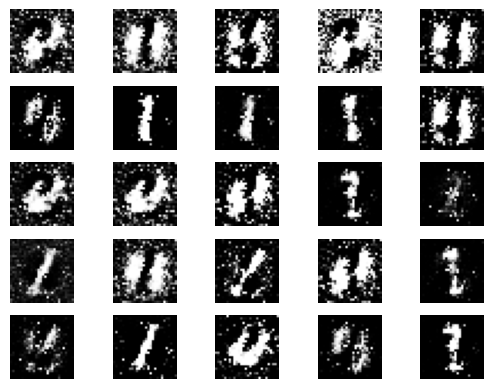

[201/400][0/16] 	Loss_D: 0.7975	Loss_G: -0.0096	D(x): 0.9521	D(G(z)): 0.4130
[202/400][0/16] 	Loss_D: 0.0666	Loss_G: -0.0263	D(x): 0.9719	D(G(z)): 0.0321
[203/400][0/16] 	Loss_D: 0.1355	Loss_G: -0.0261	D(x): 0.9144	D(G(z)): 0.0137
[204/400][0/16] 	Loss_D: 0.1964	Loss_G: -0.0022	D(x): 0.9910	D(G(z)): 0.1614
[205/400][0/16] 	Loss_D: 0.1080	Loss_G: -0.0370	D(x): 0.9673	D(G(z)): 0.0637
[206/400][0/16] 	Loss_D: 0.8242	Loss_G: -0.0286	D(x): 0.7962	D(G(z)): 0.0002
[207/400][0/16] 	Loss_D: 0.4079	Loss_G: -0.0215	D(x): 0.9278	D(G(z)): 0.2195
[208/400][0/16] 	Loss_D: 0.4474	Loss_G: -0.1701	D(x): 0.8484	D(G(z)): 0.0128
[209/400][0/16] 	Loss_D: 0.2090	Loss_G: -0.1434	D(x): 0.8940	D(G(z)): 0.0343
[210/400][0/16] 	Loss_D: 0.1270	Loss_G: -0.0666	D(x): 0.9338	D(G(z)): 0.0269
[211/400][0/16] 	Loss_D: 0.0395	Loss_G: -0.0120	D(x): 0.9911	D(G(z)): 0.0293
[212/400][0/16] 	Loss_D: 0.0328	Loss_G: -0.0125	D(x): 0.9927	D(G(z)): 0.0241
[213/400][0/16] 	Loss_D: 0.0467	Loss_G: -0.0171	D(x): 0.9697	D(G(z)): 0.0108

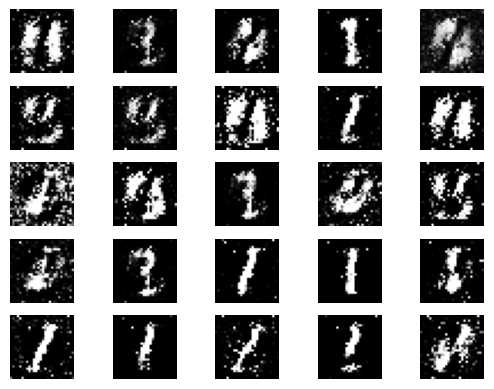

[226/400][0/16] 	Loss_D: 0.0712	Loss_G: -0.0220	D(x): 0.9707	D(G(z)): 0.0331
[227/400][0/16] 	Loss_D: 0.0588	Loss_G: -0.0264	D(x): 0.9698	D(G(z)): 0.0242
[228/400][0/16] 	Loss_D: 0.0479	Loss_G: -0.0181	D(x): 0.9829	D(G(z)): 0.0262
[229/400][0/16] 	Loss_D: 0.1069	Loss_G: -0.0039	D(x): 0.9427	D(G(z)): 0.0041
[230/400][0/16] 	Loss_D: 0.0557	Loss_G: -0.0068	D(x): 0.9695	D(G(z)): 0.0128
[231/400][0/16] 	Loss_D: 0.0537	Loss_G: -0.0325	D(x): 0.9748	D(G(z)): 0.0227
[232/400][0/16] 	Loss_D: 0.0953	Loss_G: -0.0032	D(x): 0.9958	D(G(z)): 0.0836
[233/400][0/16] 	Loss_D: 0.0265	Loss_G: -0.0070	D(x): 0.9828	D(G(z)): 0.0053
[234/400][0/16] 	Loss_D: 0.0321	Loss_G: -0.0111	D(x): 0.9915	D(G(z)): 0.0222
[235/400][0/16] 	Loss_D: 9.2908	Loss_G: -0.0000	D(x): 0.2375	D(G(z)): 0.0000
[236/400][0/16] 	Loss_D: 0.1176	Loss_G: -0.0303	D(x): 0.9499	D(G(z)): 0.0408
[237/400][0/16] 	Loss_D: 0.2545	Loss_G: -0.1155	D(x): 0.8795	D(G(z)): 0.0319
[238/400][0/16] 	Loss_D: 0.2567	Loss_G: -0.0878	D(x): 0.8983	D(G(z)): 0.0561

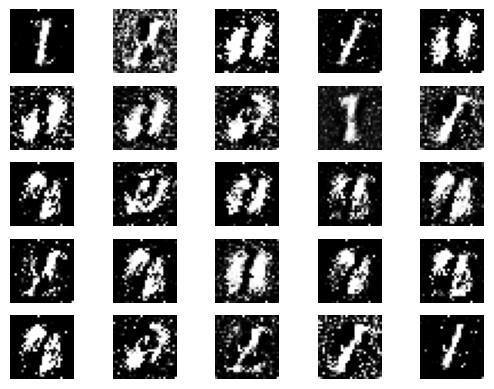

[251/400][0/16] 	Loss_D: 0.0552	Loss_G: -0.0165	D(x): 0.9784	D(G(z)): 0.0289
[252/400][0/16] 	Loss_D: 0.0556	Loss_G: -0.0142	D(x): 0.9695	D(G(z)): 0.0193
[253/400][0/16] 	Loss_D: 0.1041	Loss_G: -0.0267	D(x): 0.9497	D(G(z)): 0.0200
[254/400][0/16] 	Loss_D: 0.0374	Loss_G: -0.0082	D(x): 0.9823	D(G(z)): 0.0160
[255/400][0/16] 	Loss_D: 1.4072	Loss_G: -0.0196	D(x): 0.9387	D(G(z)): 0.3723
[256/400][0/16] 	Loss_D: 0.1620	Loss_G: -0.0293	D(x): 0.9568	D(G(z)): 0.0954
[257/400][0/16] 	Loss_D: 0.1383	Loss_G: -0.0441	D(x): 0.9305	D(G(z)): 0.0434
[258/400][0/16] 	Loss_D: 0.2069	Loss_G: -0.0720	D(x): 0.9256	D(G(z)): 0.0787
[259/400][0/16] 	Loss_D: 0.2654	Loss_G: -0.0533	D(x): 0.8983	D(G(z)): 0.0230
[260/400][0/16] 	Loss_D: 0.1872	Loss_G: -0.0248	D(x): 0.9242	D(G(z)): 0.0103
[261/400][0/16] 	Loss_D: 0.1022	Loss_G: -0.0074	D(x): 0.9490	D(G(z)): 0.0151
[262/400][0/16] 	Loss_D: 0.0980	Loss_G: -0.0143	D(x): 0.9766	D(G(z)): 0.0564
[263/400][0/16] 	Loss_D: 0.2081	Loss_G: -0.0867	D(x): 0.9710	D(G(z)): 0.1357

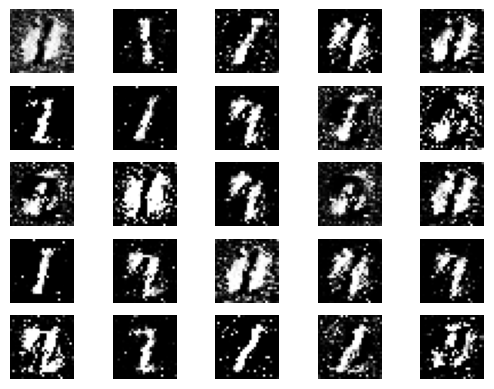

[276/400][0/16] 	Loss_D: 0.4901	Loss_G: -0.0006	D(x): 0.9775	D(G(z)): 0.3286
[277/400][0/16] 	Loss_D: 0.5432	Loss_G: -0.0022	D(x): 0.8271	D(G(z)): 0.0007
[278/400][0/16] 	Loss_D: 0.1130	Loss_G: -0.0289	D(x): 0.9582	D(G(z)): 0.0458
[279/400][0/16] 	Loss_D: 0.1078	Loss_G: -0.4447	D(x): 0.9535	D(G(z)): 0.0387
[280/400][0/16] 	Loss_D: 0.1031	Loss_G: -0.0306	D(x): 0.9686	D(G(z)): 0.0587
[281/400][0/16] 	Loss_D: 0.1210	Loss_G: -0.0385	D(x): 0.9634	D(G(z)): 0.0425
[282/400][0/16] 	Loss_D: 0.1101	Loss_G: -0.0970	D(x): 0.9458	D(G(z)): 0.0238
[283/400][0/16] 	Loss_D: 0.0896	Loss_G: -0.0122	D(x): 0.9506	D(G(z)): 0.0094
[284/400][0/16] 	Loss_D: 0.0615	Loss_G: -0.0501	D(x): 0.9664	D(G(z)): 0.0185
[285/400][0/16] 	Loss_D: 0.0456	Loss_G: -0.0132	D(x): 0.9705	D(G(z)): 0.0116
[286/400][0/16] 	Loss_D: 0.0428	Loss_G: -0.0182	D(x): 0.9762	D(G(z)): 0.0121
[287/400][0/16] 	Loss_D: 0.0437	Loss_G: -0.0147	D(x): 0.9723	D(G(z)): 0.0060
[288/400][0/16] 	Loss_D: 0.0509	Loss_G: -0.0195	D(x): 0.9765	D(G(z)): 0.0221

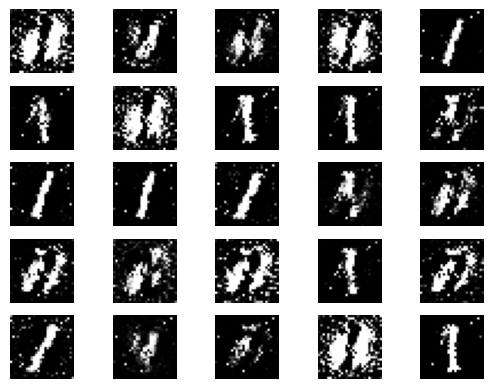

[301/400][0/16] 	Loss_D: 0.0636	Loss_G: -0.0124	D(x): 0.9602	D(G(z)): 0.0055
[302/400][0/16] 	Loss_D: 0.3324	Loss_G: -0.0001	D(x): 0.9995	D(G(z)): 0.2483
[303/400][0/16] 	Loss_D: 0.0153	Loss_G: -0.0058	D(x): 0.9942	D(G(z)): 0.0086
[304/400][0/16] 	Loss_D: 1.0034	Loss_G: -0.0180	D(x): 0.8139	D(G(z)): 0.0000
[305/400][0/16] 	Loss_D: 0.0556	Loss_G: -0.0234	D(x): 0.9690	D(G(z)): 0.0092
[306/400][0/16] 	Loss_D: 0.0391	Loss_G: -0.0129	D(x): 0.9986	D(G(z)): 0.0360
[307/400][0/16] 	Loss_D: 0.0336	Loss_G: -0.0735	D(x): 0.9958	D(G(z)): 0.0280
[308/400][0/16] 	Loss_D: 0.0569	Loss_G: -0.0146	D(x): 0.9710	D(G(z)): 0.0109
[309/400][0/16] 	Loss_D: 0.1627	Loss_G: -0.0155	D(x): 0.9214	D(G(z)): 0.0243
[310/400][0/16] 	Loss_D: 0.1668	Loss_G: -0.0538	D(x): 0.9193	D(G(z)): 0.0388
[311/400][0/16] 	Loss_D: 0.2339	Loss_G: -0.0672	D(x): 0.9240	D(G(z)): 0.0780
[312/400][0/16] 	Loss_D: 0.1661	Loss_G: -0.0575	D(x): 0.9456	D(G(z)): 0.0820
[313/400][0/16] 	Loss_D: 0.0709	Loss_G: -0.0306	D(x): 0.9792	D(G(z)): 0.0441

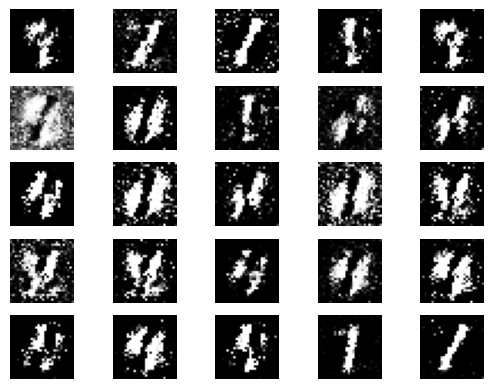

[326/400][0/16] 	Loss_D: 0.0552	Loss_G: -0.0144	D(x): 0.9796	D(G(z)): 0.0205
[327/400][0/16] 	Loss_D: 0.0648	Loss_G: -0.0076	D(x): 0.9911	D(G(z)): 0.0495
[328/400][0/16] 	Loss_D: 0.1445	Loss_G: -0.1385	D(x): 0.9264	D(G(z)): 0.0266
[329/400][0/16] 	Loss_D: 1.4308	Loss_G: -0.0523	D(x): 0.6966	D(G(z)): 0.0003
[330/400][0/16] 	Loss_D: 0.3127	Loss_G: -0.0465	D(x): 0.9567	D(G(z)): 0.2034
[331/400][0/16] 	Loss_D: 0.3134	Loss_G: -0.0740	D(x): 0.9001	D(G(z)): 0.0750
[332/400][0/16] 	Loss_D: 0.2827	Loss_G: -0.0620	D(x): 0.9234	D(G(z)): 0.1243
[333/400][0/16] 	Loss_D: 0.1304	Loss_G: -0.0512	D(x): 0.9574	D(G(z)): 0.0677
[334/400][0/16] 	Loss_D: 0.0492	Loss_G: -0.0178	D(x): 0.9894	D(G(z)): 0.0363
[335/400][0/16] 	Loss_D: 0.0602	Loss_G: -0.0193	D(x): 0.9696	D(G(z)): 0.0185
[336/400][0/16] 	Loss_D: 0.0285	Loss_G: -0.0082	D(x): 0.9789	D(G(z)): 0.0055
[337/400][0/16] 	Loss_D: 0.0143	Loss_G: -0.0051	D(x): 0.9929	D(G(z)): 0.0068
[338/400][0/16] 	Loss_D: 0.0091	Loss_G: -0.0036	D(x): 0.9953	D(G(z)): 0.0042

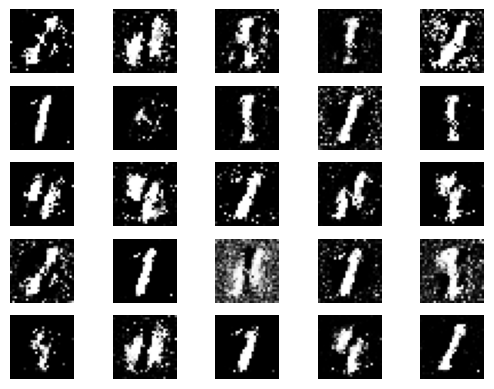

[351/400][0/16] 	Loss_D: 0.4229	Loss_G: -0.0495	D(x): 0.8352	D(G(z)): 0.0294
[352/400][0/16] 	Loss_D: 0.6081	Loss_G: -0.0345	D(x): 0.8961	D(G(z)): 0.2658
[353/400][0/16] 	Loss_D: 0.1215	Loss_G: -0.0421	D(x): 0.9392	D(G(z)): 0.0407
[354/400][0/16] 	Loss_D: 0.0676	Loss_G: -0.0171	D(x): 0.9820	D(G(z)): 0.0418
[355/400][0/16] 	Loss_D: 0.0741	Loss_G: -0.0127	D(x): 0.9722	D(G(z)): 0.0352
[356/400][0/16] 	Loss_D: 0.0175	Loss_G: -0.0060	D(x): 0.9911	D(G(z)): 0.0081
[357/400][0/16] 	Loss_D: 0.0481	Loss_G: -0.0162	D(x): 0.9766	D(G(z)): 0.0165
[358/400][0/16] 	Loss_D: 0.0174	Loss_G: -0.0054	D(x): 0.9928	D(G(z)): 0.0096
[359/400][0/16] 	Loss_D: 0.0097	Loss_G: -0.0032	D(x): 0.9941	D(G(z)): 0.0036
[360/400][0/16] 	Loss_D: 0.0113	Loss_G: -0.0053	D(x): 0.9936	D(G(z)): 0.0045
[361/400][0/16] 	Loss_D: 0.0577	Loss_G: -0.0061	D(x): 0.9959	D(G(z)): 0.0438
[362/400][0/16] 	Loss_D: 0.0109	Loss_G: -0.0054	D(x): 0.9987	D(G(z)): 0.0094
[363/400][0/16] 	Loss_D: 0.0290	Loss_G: -0.0027	D(x): 0.9832	D(G(z)): 0.0012

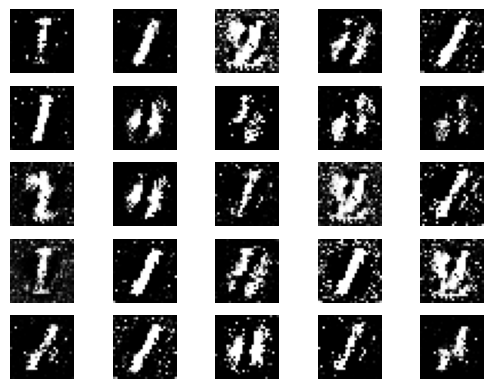

[376/400][0/16] 	Loss_D: 0.1577	Loss_G: -0.0047	D(x): 0.9780	D(G(z)): 0.1035
[377/400][0/16] 	Loss_D: 0.4878	Loss_G: -0.0762	D(x): 0.8071	D(G(z)): 0.0171
[378/400][0/16] 	Loss_D: 0.2142	Loss_G: -0.0628	D(x): 0.9528	D(G(z)): 0.1294
[379/400][0/16] 	Loss_D: 0.1260	Loss_G: -0.0398	D(x): 0.9406	D(G(z)): 0.0333
[380/400][0/16] 	Loss_D: 0.0890	Loss_G: -0.0269	D(x): 0.9756	D(G(z)): 0.0536
[381/400][0/16] 	Loss_D: 0.0394	Loss_G: -0.0110	D(x): 0.9953	D(G(z)): 0.0332
[382/400][0/16] 	Loss_D: 0.0199	Loss_G: -0.0054	D(x): 0.9881	D(G(z)): 0.0071
[383/400][0/16] 	Loss_D: 0.0291	Loss_G: -0.0054	D(x): 0.9870	D(G(z)): 0.0143
[384/400][0/16] 	Loss_D: 0.0181	Loss_G: -0.0056	D(x): 0.9890	D(G(z)): 0.0064
[385/400][0/16] 	Loss_D: 0.0428	Loss_G: -0.0074	D(x): 0.9921	D(G(z)): 0.0321
[386/400][0/16] 	Loss_D: 0.0272	Loss_G: -0.0073	D(x): 0.9852	D(G(z)): 0.0105
[387/400][0/16] 	Loss_D: 0.0135	Loss_G: -0.0022	D(x): 0.9918	D(G(z)): 0.0040
[388/400][0/16] 	Loss_D: 0.0159	Loss_G: -0.0055	D(x): 0.9890	D(G(z)): 0.0040

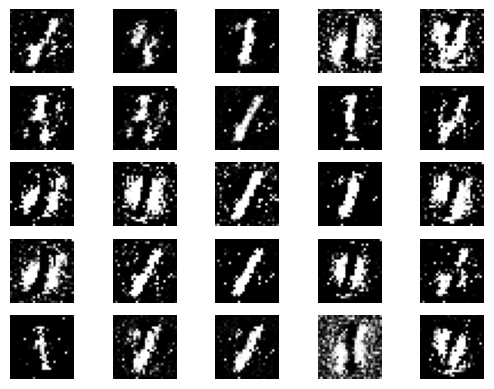

In [36]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

sample_interval=25

print("Starting Training")
# For each epoch
for epoch in range(n_epochs):
  # For each batch in the dataloader
  for i, data in enumerate(mnist_train_loader, 0):
    for iter_inner in range(0,n_iters_inner):
        
      ############################
      ### Train discriminator
      ############################
      ## Train with true data batch
      disc_model.zero_grad()
      # create true data and labels 
      true_imgs = data[0] # FILL IN HERE
      true_labels = data[1] # FILL IN HERE
      # put true data through discriminator
      d_output_true = disc_model(true_imgs) # FILL IN HERE
      # bce loss on true data
      d_loss_true = bce_criterion(d_output_true.flatten(), torch.ones(len(data[1]))) # FILL IN HERE
      # backpropagation for discriminator, true loss
      d_loss_true.backward()
      disc_true_value = d_output_true.mean().item()

      ## Train with fake data batch
      # create fake data and labels
      # generate batch of random latent vectors
      z_latent_noise = torch.rand(batch_size, z_dim) # FILL IN HERE
      # Generate batch of fake images
      fake_imgs = gen_model(z_latent_noise) # FILL IN HERE
      #fake_labels = ... # FILL IN HERE
      # put fake data through discriminator
      disc_output_fake = disc_model(fake_imgs.detach()) # FILL IN HERE
      # bce loss on fake data
      disc_loss_fake = bce_criterion(disc_output_fake.flatten(), torch.zeros(len(disc_output_fake.flatten()))) # FILL IN HERE
      # backpropagation for discriminator, fake loss
      disc_loss_fake.backward()
      disc_fake_value = disc_output_fake.mean().item()
      # Update discriminator
      optimizer_disc.step()

      d_loss_total = d_loss_true+disc_loss_fake

    ############################
    ### Train generator
    ############################
    gen_model.zero_grad()
    # We have updated the discriminator, so we need to update the output of the discriminator
    disc_gen_output_fake = disc_model(fake_imgs) # FILL IN HERE
    # Generator loss, using the custom loss
    g_loss = loss_fn_gen(disc_gen_output_fake) # FILL IN HERE
    # backpropagation for generator
    g_loss.backward()
    #D_G_z2 = output.mean().item()
    # Update generator
    optimizer_gen.step()

    # Output training stats
    if i % 200 == 0:
      print('[%d/%d][%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
      % (epoch, n_epochs, i, len(mnist_train_loader),d_loss_total.item(), g_loss.item(), disc_true_value, disc_fake_value ))

    # Save Losses for plotting later
    G_losses.append(g_loss.item())
    D_losses.append(d_loss_total.item())

  if(epoch % sample_interval == 0):
    sample_images(gen_model,z_dim, rand_seed=30)

# end samples
sample_images(gen_model,z_dim, rand_seed=30)


## 6/ Navigating in the latent space

One of the main interests in the latent space is to be able to __navigate__ in it. For instance, one operation which is very common is to take two points $z_0$ and $z_1$ and to interpolate between the two. The images resulting from the generation of the interpolated points should ideally be a mix between the two initial points. 

The simplest method of interpolation is simply linear interpolation along the line connecting the two points. Obviously, this supposes that the latent space is linear in some sense, which may not be true, but we are going to take this approach here. 

First, find two inital points $z_0$ and $z_1$ which you feel represent two different digits well, and display their resulting generated images.  

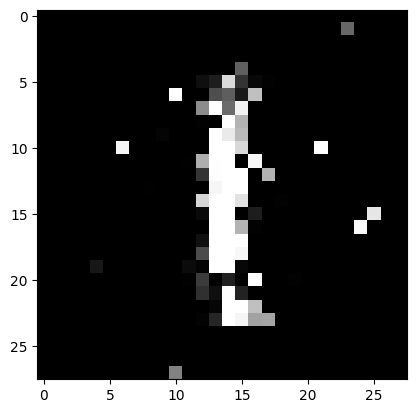

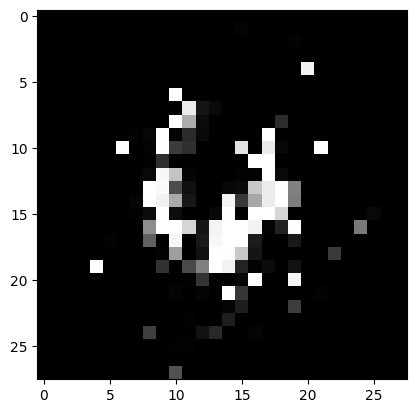

In [55]:
# first image
random_seed = 3522 # change this seed to find the best image
torch.manual_seed(random_seed)
z_0 = torch.rand(z_dim) # FILL IN HERE
x_0 = gen_model(z_0) # FILL IN HERE

random_seed = 173523 # change this seed to find the best image
torch.manual_seed(random_seed)
z_1 = torch.rand(z_dim) # FILL IN HERE
x_1 = gen_model(z_1) # FILL IN HERE

# display images
# FILL IN HERE
plt.imshow(x_0.view(28, 28).detach().numpy(), cmap='gray')
plt.show()
plt.imshow(x_1.view(28, 28).detach().numpy(), cmap='gray')
plt.show()

Now, carry out the interpolation between these two points. You should __include__ the starting and ending codes $z_0$ and $z_1$. Display the results.

In [69]:
n_interpolation = 20

# FILL IN HERE

imgs = torch.zeros(n_interpolation, 1, 1, 28, 28)
for i in range(n_interpolation):
  ratio = i / n_interpolation
  z_inter = ratio * z_0 + (1 - ratio) * z_1
  imgs[i] = gen_model(z_inter)

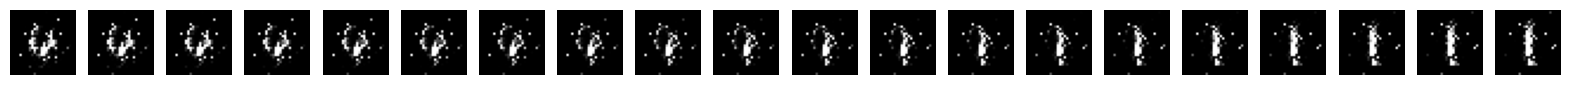

In [70]:
# display results

fig, axs = plt.subplots(1, n_interpolation,figsize=(20,20))
for i in range(n_interpolation):
  #black and white images
  axs[i].imshow(imgs[i].view(28, 28).detach().numpy() , cmap='gray')  # FILL IN HERE
  axs[i].axis('off')
plt.show()

What do you think of the quality of the output images ?

__Answer__

I have the impression that the GAN is entered in mode collapse. So it's very complicated to get two different digits. And the result of the linear interpolation is that we can't recognize the digits, this is mostly a mix of the two digits.

## 7/ Evaluation of navigation

Now, we are going to evaluate this navigation. We will investigate two properties:

- 1/ We are going to see whether by navigating between two points, the model produces images which are categorised in either of the classes (beginning class or end class), or if it traverses a region which is categorised in another class;
- 2/ We are going to see whether the confidence of a classification network in different regions varies much. In other words, when we navigate in the latent space, do we go into zones which do not correspond to any number (according to the classification network) ? 

For this, we will first need a classification network. Take the code from the last lab work on variational autoencoders, and extract the section where we trained a classifier on mnist. Here is the architecture we used:

- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- conv2d, filter size  3×3 , 32 filters, stride=(2,2), padding="SAME"
- ReLU
- MaxPool2D, stride=(2,2)
- Flatten
- Dense layer

In [58]:
# define mnist classifier model, loss function, optimiser and the function 'get_accuracy'
learning_rate = 0.01
n_epochs = 20
batch_size = 64
nb_classes = int(mnist_trainset.targets.max()+1)

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

# --- Size of the successive layers
n_h_0 = 1 #greyscale input images
n_h_1 = nb_filters
n_h_2 = nb_filters

mnist_classification_model = nn.Sequential(
    nn.Conv2d(1, nb_filters, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(nb_filters, nb_filters, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(288, 10)
) # FILL IN CODE HERE

criterion = nn.CrossEntropyLoss() # FILL IN CODE HERE
optimizer = torch.optim.Adam(mnist_classification_model.parameters(), lr=learning_rate)
# FILL IN HERE

def get_accuracy(x_pred,x_label):
  acc = torch.sum(x_pred == x_label)/(x_pred.shape[0])
  return acc

In [59]:
# training the classifier
train_losses=[]
valid_losses=[]

for epoch in range(0,n_epochs):
  train_loss=0.0

  for batch_idx, (imgs, labels) in enumerate(mnist_train_loader):

    # set the gradients back to 0
    optimizer.zero_grad()
    predict=mnist_classification_model(imgs)
    # apply loss function
    loss=criterion(predict,labels)
    acc = get_accuracy(torch.argmax(predict,dim=1),labels)
    # backpropagation
    loss.backward()
    optimizer.step()
    train_loss=loss.item()
  print('Epoch:{} Train Loss:{:.4f} Accuracy:{:.4f}'.format(epoch,train_loss/imgs.shape[0],acc))
# FILL IN HERE

Epoch:0 Train Loss:0.0221 Accuracy:0.6500
Epoch:1 Train Loss:0.0129 Accuracy:0.7750
Epoch:2 Train Loss:0.0105 Accuracy:0.9000
Epoch:3 Train Loss:0.0101 Accuracy:0.8750
Epoch:4 Train Loss:0.0061 Accuracy:0.9250
Epoch:5 Train Loss:0.0019 Accuracy:0.9750
Epoch:6 Train Loss:0.0012 Accuracy:0.9750
Epoch:7 Train Loss:0.0029 Accuracy:0.9500
Epoch:8 Train Loss:0.0003 Accuracy:1.0000
Epoch:9 Train Loss:0.0018 Accuracy:0.9750
Epoch:10 Train Loss:0.0003 Accuracy:1.0000
Epoch:11 Train Loss:0.0014 Accuracy:0.9750
Epoch:12 Train Loss:0.0017 Accuracy:0.9750
Epoch:13 Train Loss:0.0002 Accuracy:1.0000
Epoch:14 Train Loss:0.0001 Accuracy:1.0000
Epoch:15 Train Loss:0.0000 Accuracy:1.0000
Epoch:16 Train Loss:0.0001 Accuracy:1.0000
Epoch:17 Train Loss:0.0000 Accuracy:1.0000
Epoch:18 Train Loss:0.0000 Accuracy:1.0000
Epoch:19 Train Loss:0.0000 Accuracy:1.0000


### 7.1/ Evaluation of navigation part 1

Now, create a function which returns the classification returned by this network on mnist images. Remember, the classification model above returns the values __before__ the softmax is applied, and here we want the argmax, rather than the maximum probability. __Note__: the torch.max function returns a tuple: (max_values, max_indices).


In [77]:
def predict_mnist_class(imgs_in,classification_model):
  output_classes = torch.argmax(classification_model(imgs_in)) # FILL IN HERE
  return(output_classes)

Carry out and print the classification of your interpolated latent space images. What are your remarks ? Does the latent space navigation traverse regions with classes other than those of $z_0$ and $z_1$ ?

In [80]:
z_classes = []
for data in imgs:
  z_classes.append(predict_mnist_class(data, mnist_classification_model).item()) # FILL IN HERE
print(z_classes)

[4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


__Answer__

We see that it passes from a digit to another without traversing others digits.

### 7.2/ Evaluation of navigation part 2

Even though the network may predict coherent image classes during the navigation, it may predict these classes with different confidences. Ideally, we would like the latent space to contain codes which produce images of constant quality. Therefore, as mentioned above, we want to check these prediction confidences during navigation on our GAN.

Carry this out now. First of all, define a function which, instead of funding the output *classes* of the interpolations, find the *probability* of the most likely class (the same operation as in the lab on variational autoencoders).


In [81]:
def predict_mnist_confidence(imgs_in,classification_model):
  output_classes = torch.max(F.softmax(classification_model(imgs_in))) # FILL IN HERE
  return(output_classes)

Using this function, carry out the second evaluation on the images generated by interpolated latent codes.

In [82]:
z_confidence = []
for data in imgs:
  z_confidence.append(predict_mnist_confidence(data, mnist_classification_model).item()) # FILL IN HERE
print(z_confidence)

[0.999962329864502, 0.9999498128890991, 0.9998975992202759, 0.9996352195739746, 0.9974554181098938, 0.9651659727096558, 0.4641346335411072, 0.9527494311332703, 0.9950863718986511, 0.9986894726753235, 0.9994694590568542, 0.9997171759605408, 0.9998217225074768, 0.9999186992645264, 0.9999696016311646, 0.9999852180480957, 0.9999850988388062, 0.9999810457229614, 0.9999783039093018, 0.999976396560669]


<ipython-input-81-f66489206b58>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output_classes = torch.max(F.softmax(classification_model(imgs_in))) # FILL IN HERE


Does the confidence change greatly during interpolation ? Does the navigation go through zones where the classification is not confident ? Why do you think this is ? (think about the form/shape of the latent space).

\__Answer__

The confidence is around 1 when we are near z_0 or z_1 but when we are nearly the frontier the confidence is very bad. 

# __Optional__ : Training on CIFAR

If you want to try another, more challenging database, use the above code and modify it to carry out the GAN training on the CIFAR10 database. Note, it can take a long time to get good results

First, we download the data.

In [ ]:
# convert input to Pytorch tensors
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

# extract mnist data
cifar_trainset = datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
print(cifar_trainset)

#create data loader with smaller dataset size
max_cifar_size = 2000
cifar_trainset_reduced = torch.utils.data.random_split(cifar_trainset, [max_cifar_size, len(cifar_trainset)-max_cifar_size])[0] 
cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset_reduced, batch_size=64, shuffle=True)

# download test dataset
cifar_testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=64, shuffle=True)

n_rows = 32
n_cols = 32
n_channels = 3
n_pixels = n_rows*n_cols

img_shape = (n_rows, n_cols, n_channels)

Now, we can redefine the hyper-parameters of the model (change if you wish)

In [ ]:
## GAN parameters
z_dim = 10
batch_size = 64
n_epochs = 300
## parameters for training
n_iters_inner=1	#number of internal loops
# Learning rate for optimizers
lr = 0.0002
beta_1 = 0.5

For this case of CIFAR, implement the following architecture :

- Generator :
  - Dense layer to size 1024
  - Leaky ReLU ($\alpha=0.2$)
  - Reshape, to size $4 \times 4 \times64$
  - % size = $4\times4\times64$
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $8\times 8\times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=16,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size=$16 \times 16 \times 16$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2d, n_channels=3,kernel size=(3,3), strides=(1,1),padding=(1,1)
  - Upsample(scale_factor=(2,2))
  - %size = $32 \times 32 \times 3$
  - Tanh activation ( you can use ```Activation('tanh')```)

- Discriminator :
  - % input size : $32 \times 32 \times 3$
  - Conv2D, 32 filters, kernel size = (3,3), strides = (1,1),padding = same
  - % size $32 \times 32 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - %size : $16 \times 16 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 64 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $8 \times 8 \times 64$
  - Leaky ReLU ($\alpha=0.2$)
  - Conv2D, 32 filters, kernel size = (3,3), strides = (2,2),padding = same
  - % size : $4 \times 4 \times 32$
  - Leaky ReLU ($\alpha=0.2$)
  - Flatten
  - Dense layer to size 1
  - Sigmoid activation

  Implement this architecture below, and train the GAN. 

In [ ]:
# GAN implementation

# FILL IN HERE

Now, carry out the training (use code above)

In [ ]:
# training code

# FILL IN HERE